In [1]:
import vaex
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import collections

import numpy as np
import pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = vaex.open('yellow_tripdata_2010_filtered.hdf5', progress=True)

In [3]:
geo_filename = './aux_data/taxi_zones-tiny.json'
with open(geo_filename) as f:
    geo_json = json.load(f)

features = geo_json['features']
borough_polygons = collections.defaultdict(list)
zone_polygons = collections.defaultdict(list)
zbmapper = {}
list_of_polygons = []

for i, feature in enumerate(features[:]):
    properties = feature['properties']
    geo = feature['geometry']

    polygons = []
    for polygon in geo['coordinates']:
        polygon = np.array(polygon)
        if polygon.ndim == 3:
            polygon = polygon[0]
        polygon = polygon.T
        assert polygon.shape[0] == 2
        assert polygon.ndim == 2
        polygons.append(polygon)

    borough_polygons[properties['borough']].extend(polygons)
    zone_polygons[properties['zone']].extend(polygons)
    zbmapper[properties['zone']] = properties['borough']
    
keys = list(borough_polygons.keys())
bmapper = {i:keys[i] for i in range(len(keys))}
keys = list(zone_polygons.keys())
zmapper = {i:keys[i] for i in range(len(keys))}

with open('./aux_data/zone.json', 'w') as f:
    json.dump(zmapper, f)
with open('./aux_data/borough.json', 'w') as f:
    json.dump(bmapper, f)
with open('./aux_data/zone_to_borough.json', 'w') as f:
    json.dump(zbmapper, f)

In [4]:
# Add the borough and zone ids to the pickup and dropoff locations as virtual columns

df['dropoff_borough'] = df.geo.inside_which_polygons(df.dropoff_longitude, df.dropoff_latitude, borough_polygons.values()).astype('uint8')
df['dropoff_zone'] = df.geo.inside_which_polygons(df.dropoff_longitude, df.dropoff_latitude, zone_polygons.values()).astype('uint16')

df['pickup_borough'] = df.geo.inside_which_polygons(df.pickup_longitude, df.pickup_latitude, borough_polygons.values()).astype('uint8')
df['pickup_zone'] = df.geo.inside_which_polygons(df.pickup_longitude, df.pickup_latitude, zone_polygons.values()).astype('uint16')

df.head_and_tail_print()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone
0,VTS,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.956778,40.76775,1,--,-73.965957,40.765232,CASH,4.5,0.0,0.5,0.0,0.0,5.0,4.0,11.25,4,75,4,115
1,DDS,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.99611799999998,40.763932,1,--,-73.98151199999998,40.741193,CASH,15.3,0.5,0.5,0.0,0.0,16.3,15.2,23.289473684210527,4,160,4,140
2,DDS,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4.0,-73.979673,40.78379,1,--,-73.91785199999998,40.87856,CASH,11.7,0.5,0.5,0.0,0.0,12.7,15.866666666666667,15.126050420168069,3,241,4,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"163,170,054",CMT,2010-12-02 00:44:45.000000000,2010-12-02 00:54:41.000000000,1,2.6,-73.99100199999998,40.740599,1,N,-73.998046,40.74686,CRED,8.9,0.5,0.5,1.48,0.0,11.38,9.933333333333334,15.70469798657718,4,150,4,217
"163,170,055",CMT,2010-12-02 00:17:46.000000000,2010-12-02 00:23:37.000000000,1,1.6,-74.005401,40.744262,1,N,-73.987623,40.760235,CRED,6.5,0.5,0.5,1.0,0.0,8.5,5.85,16.410256410256412,4,139,4,150


In [5]:
df.materialize(column='dropoff_borough', inplace=True)
df.materialize(column='dropoff_zone', inplace=True)
df.materialize(column='pickup_borough', inplace=True)
df.materialize(column='pickup_zone', inplace=True)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone
0,VTS,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.956778,40.76775,1,--,-73.965957,40.765232,CASH,4.5,0.0,0.5,0.0,0.0,5.0,4.0,11.25,4,75,4,115
1,DDS,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.99611799999998,40.763932,1,--,-73.98151199999998,40.741193,CASH,15.3,0.5,0.5,0.0,0.0,16.3,15.2,23.289473684210527,4,160,4,140
2,DDS,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4.0,-73.979673,40.78379,1,--,-73.91785199999998,40.87856,CASH,11.7,0.5,0.5,0.0,0.0,12.7,15.866666666666667,15.126050420168069,3,241,4,212
3,VTS,2010-01-09 01:18:00.000000000,2010-01-09 01:35:00.000000000,2,4.7,-73.977922,40.763997,1,--,-73.92390799999998,40.759725,CASH,13.3,0.5,0.5,0.0,0.0,14.3,17.0,16.58823529411765,0,103,4,117
4,CMT,2010-01-18 19:10:14.000000000,2010-01-18 19:17:07.000000000,1,0.5999999999999999,-73.990924,40.734682,1,0,-73.99551099999998,40.739088,CRED,5.3,0.0,0.5,0.87,0.0,6.67,6.883333333333334,5.230024213075059,4,217,4,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"163,170,051",VTS,2010-12-05 01:56:00.000000000,2010-12-05 02:02:00.000000000,2,1.3,-73.98385,40.749142,1,--,-73.969747,40.756967,CRED,5.7,0.5,0.5,1.0,0.0,7.7,6.0,13.0,4,68,4,187
"163,170,052",CMT,2010-12-02 01:11:19.000000000,2010-12-02 01:14:53.000000000,1,1.4,-73.957606,40.717869,1,N,-73.955151,40.735764,CRED,5.3,0.5,0.5,1.26,0.0,7.559999999999999,3.566666666666667,23.551401869158877,2,57,2,248
"163,170,053",CMT,2010-12-02 01:07:41.000000000,2010-12-02 01:39:34.000000000,2,12.1,-73.989767,40.729652,1,N,-74.033006,40.618895,CRED,30.9,0.5,0.5,6.38,0.0,38.28,31.883333333333333,22.77051751176163,2,114,4,44
"163,170,054",CMT,2010-12-02 00:44:45.000000000,2010-12-02 00:54:41.000000000,1,2.6,-73.99100199999998,40.740599,1,N,-73.998046,40.74686,CRED,8.9,0.5,0.5,1.48,0.0,11.38,9.933333333333334,15.70469798657718,4,150,4,217


In [6]:
# Extract some date/time features

df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_day_of_week'] = df.pickup_datetime.dt.dayofweek
df['pickup_month'] = df.pickup_datetime.dt.month - 1  # to count from zero
df['pickup_is_weekend'] = (df.pickup_day_of_week>=5)


# Treat these columns as label/ordinal encoded values

df.categorize(column='pickup_hour', inplace=True)
df.categorize(column='pickup_day_of_week', labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], inplace=True)
df.categorize(column='pickup_month', inplace=True)



#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone,pickup_hour,pickup_day_of_week,pickup_month,pickup_is_weekend
0,VTS,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.956778,40.76775,1,--,-73.965957,40.765232,CASH,4.5,0.0,0.5,0.0,0.0,5.0,4.0,11.25,4,75,4,115,7,1,0,False
1,DDS,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.99611799999998,40.763932,1,--,-73.98151199999998,40.741193,CASH,15.3,0.5,0.5,0.0,0.0,16.3,15.2,23.289473684210527,4,160,4,140,23,5,0,True
2,DDS,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4.0,-73.979673,40.78379,1,--,-73.91785199999998,40.87856,CASH,11.7,0.5,0.5,0.0,0.0,12.7,15.866666666666667,15.126050420168069,3,241,4,212,20,0,0,False
3,VTS,2010-01-09 01:18:00.000000000,2010-01-09 01:35:00.000000000,2,4.7,-73.977922,40.763997,1,--,-73.92390799999998,40.759725,CASH,13.3,0.5,0.5,0.0,0.0,14.3,17.0,16.58823529411765,0,103,4,117,1,5,0,True
4,CMT,2010-01-18 19:10:14.000000000,2010-01-18 19:17:07.000000000,1,0.5999999999999999,-73.990924,40.734682,1,0,-73.99551099999998,40.739088,CRED,5.3,0.0,0.5,0.87,0.0,6.67,6.883333333333334,5.230024213075059,4,217,4,177,19,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"163,170,051",VTS,2010-12-05 01:56:00.000000000,2010-12-05 02:02:00.000000000,2,1.3,-73.98385,40.749142,1,--,-73.969747,40.756967,CRED,5.7,0.5,0.5,1.0,0.0,7.7,6.0,13.0,4,68,4,187,1,6,11,True
"163,170,052",CMT,2010-12-02 01:11:19.000000000,2010-12-02 01:14:53.000000000,1,1.4,-73.957606,40.717869,1,N,-73.955151,40.735764,CRED,5.3,0.5,0.5,1.26,0.0,7.559999999999999,3.566666666666667,23.551401869158877,2,57,2,248,1,3,11,False
"163,170,053",CMT,2010-12-02 01:07:41.000000000,2010-12-02 01:39:34.000000000,2,12.1,-73.989767,40.729652,1,N,-74.033006,40.618895,CRED,30.9,0.5,0.5,6.38,0.0,38.28,31.883333333333333,22.77051751176163,2,114,4,44,1,3,11,False
"163,170,054",CMT,2010-12-02 00:44:45.000000000,2010-12-02 00:54:41.000000000,1,2.6,-73.99100199999998,40.740599,1,N,-73.998046,40.74686,CRED,8.9,0.5,0.5,1.48,0.0,11.38,9.933333333333334,15.70469798657718,4,150,4,217,0,3,11,False


In [7]:
# direct distance from point A to point B
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2 + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Expression to be pre-compiled with numba, and then executed
df['arc_distance'] = arc_distance(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude).jit_numba()

count [########################################] 100.00% elapsed time  :     0.00s =  0.0m =  0.0h
count [########################################] 100.00% elapsed time  :     1.71s =  0.0m =  0.0h 
count [########################################] 100.00% elapsed time  :     0.00s =  0.0m =  0.0h
count [########################################] 100.00% elapsed time  :     5.32s =  0.1m =  0.0h
 

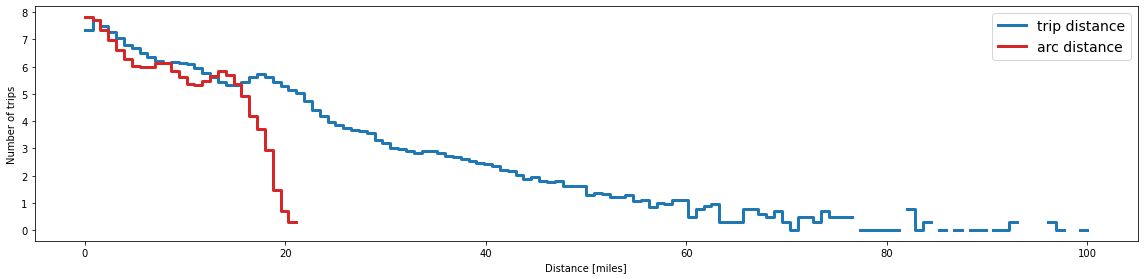

In [8]:
plt.figure(figsize=(16, 4))

df.plot1d('trip_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C0', 
                   label='trip distance', progress=True)
df.plot1d('arc_distance', shape=128, limits=[0, 100], lw=3, f='log10', color='C3', 
                   label='arc distance', progress=True)
plt.legend(fontsize=14)
plt.xlabel('Distance [miles]')
plt.ylabel('Number of trips')

plt.show()

In [9]:
df.head()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone,pickup_hour,pickup_day_of_week,pickup_month,pickup_is_weekend,arc_distance
0,VTS,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.9568,40.7677,1,--,-73.966,40.7652,CASH,4.5,0,0.5,0,0,5,4,11.25,4,75,4,115,7,1,0,False,0.636034
1,DDS,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.9961,40.7639,1,--,-73.9815,40.7412,CASH,15.3,0.5,0.5,0,0,16.3,15.2,23.2895,4,160,4,140,23,5,0,True,1.0983
2,DDS,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4,-73.9797,40.7838,1,--,-73.9179,40.8786,CASH,11.7,0.5,0.5,0,0,12.7,15.8667,15.1261,3,241,4,212,20,0,0,False,4.63933
3,VTS,2010-01-09 01:18:00.000000000,2010-01-09 01:35:00.000000000,2,4.7,-73.9779,40.764,1,--,-73.9239,40.7597,CASH,13.3,0.5,0.5,0,0,14.3,17,16.5882,0,103,4,117,1,5,0,True,3.73294
4,CMT,2010-01-18 19:10:14.000000000,2010-01-18 19:17:07.000000000,1,0.6,-73.9909,40.7347,1,0,-73.9955,40.7391,CRED,5.3,0,0.5,0.87,0,6.67,6.88333,5.23002,4,217,4,177,19,0,0,False,0.327864
5,VTS,2010-01-17 09:18:00.000000000,2010-01-17 09:25:00.000000000,1,1.33,-73.9937,40.7549,1,--,-73.9847,40.7559,CASH,6.1,0,0.5,0,0,6.6,7,11.4,4,234,4,150,9,6,0,True,0.624355
6,VTS,2010-01-09 13:49:00.000000000,2010-01-09 13:56:00.000000000,1,1.83,-73.971,40.7513,1,--,-73.9906,40.7349,CASH,6.9,0,0.5,0,0,7.4,7,15.6857,4,217,4,246,13,5,0,True,1.3851
7,VTS,2010-01-09 00:25:00.000000000,2010-01-09 00:39:00.000000000,1,3.28,-73.99,40.7256,1,--,-73.9938,40.7617,CASH,11.3,0.5,0.5,0,0,12.3,14,14.0571,4,139,4,44,0,5,0,True,0.735747
8,VTS,2010-01-27 18:15:00.000000000,2010-01-27 18:29:00.000000000,1,1.42,-73.9796,40.7438,1,--,-73.9894,40.7568,CRED,8.5,1,0.5,2,0,12,14,6.08571,4,48,4,187,18,2,0,False,0.72058
9,VTS,2010-01-08 16:05:00.000000000,2010-01-08 16:13:00.000000000,1,0.84,-74.0009,40.7573,1,--,-73.9898,40.7574,CRED,5.7,1,0.5,3,0,10.2,8,6.3,4,139,4,255,16,4,0,False,0.770403


In [10]:
df = df.drop(['rate_code', 'store_and_fwd_flag', 'surcharge', 'mta_tax', 'tolls_amount'])

In [11]:
# Drop missing values
df = df.dropna(column_names=['dropoff_longitude', 'dropoff_latitude'])

# Drop missing pickup and dropoff locations
df = df.dropmissing(['dropoff_borough', 'dropoff_zone', 'pickup_borough', 'pickup_zone'])


In [12]:

df.shape

(162256905, 24)

In [15]:
vendors_dict = {'VTS':0, 'CMT':1, 'DDS':2}
df['vendor_id'] = df['vendor_id'].apply(lambda x: vendors_dict[x])



In [16]:
df.head()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone,pickup_hour,pickup_day_of_week,pickup_month,pickup_is_weekend,arc_distance,vendor_id_new
0,0,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.9568,40.7677,-73.966,40.7652,CASH,4.5,0,5,4,11.25,4,75,4,115,7,1,0,False,0.636034,0
1,2,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.9961,40.7639,-73.9815,40.7412,CASH,15.3,0,16.3,15.2,23.2895,4,160,4,140,23,5,0,True,1.0983,2
2,2,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4,-73.9797,40.7838,-73.9179,40.8786,CASH,11.7,0,12.7,15.8667,15.1261,3,241,4,212,20,0,0,False,4.63933,2
3,0,2010-01-09 01:18:00.000000000,2010-01-09 01:35:00.000000000,2,4.7,-73.9779,40.764,-73.9239,40.7597,CASH,13.3,0,14.3,17,16.5882,0,103,4,117,1,5,0,True,3.73294,0
4,1,2010-01-18 19:10:14.000000000,2010-01-18 19:17:07.000000000,1,0.6,-73.9909,40.7347,-73.9955,40.7391,CRED,5.3,0.87,6.67,6.88333,5.23002,4,217,4,177,19,0,0,False,0.327864,1
5,0,2010-01-17 09:18:00.000000000,2010-01-17 09:25:00.000000000,1,1.33,-73.9937,40.7549,-73.9847,40.7559,CASH,6.1,0,6.6,7,11.4,4,234,4,150,9,6,0,True,0.624355,0
6,0,2010-01-09 13:49:00.000000000,2010-01-09 13:56:00.000000000,1,1.83,-73.971,40.7513,-73.9906,40.7349,CASH,6.9,0,7.4,7,15.6857,4,217,4,246,13,5,0,True,1.3851,0
7,0,2010-01-09 00:25:00.000000000,2010-01-09 00:39:00.000000000,1,3.28,-73.99,40.7256,-73.9938,40.7617,CASH,11.3,0,12.3,14,14.0571,4,139,4,44,0,5,0,True,0.735747,0
8,0,2010-01-27 18:15:00.000000000,2010-01-27 18:29:00.000000000,1,1.42,-73.9796,40.7438,-73.9894,40.7568,CRED,8.5,2,12,14,6.08571,4,48,4,187,18,2,0,False,0.72058,0
9,0,2010-01-08 16:05:00.000000000,2010-01-08 16:13:00.000000000,1,0.84,-74.0009,40.7573,-73.9898,40.7574,CRED,5.7,3,10.2,8,6.3,4,139,4,255,16,4,0,False,0.770403,0


In [19]:
df['pickup_month'] = df.pickup_datetime.dt.month
df.head()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,total_amount,trip_duration_min,trip_speed_mph,dropoff_borough,dropoff_zone,pickup_borough,pickup_zone,pickup_hour,pickup_day_of_week,pickup_month,pickup_is_weekend,arc_distance,vendor_id_new
0,0,2010-01-26 07:41:00.000000000,2010-01-26 07:45:00.000000000,1,0.75,-73.9568,40.7677,-73.966,40.7652,CASH,4.5,0,5,4,11.25,4,75,4,115,7,1,1,False,0.636034,0
1,2,2010-01-30 23:31:00.000000000,2010-01-30 23:46:12.000000000,1,5.9,-73.9961,40.7639,-73.9815,40.7412,CASH,15.3,0,16.3,15.2,23.2895,4,160,4,140,23,5,1,True,1.0983,2
2,2,2010-01-18 20:22:20.000000000,2010-01-18 20:38:12.000000000,1,4,-73.9797,40.7838,-73.9179,40.8786,CASH,11.7,0,12.7,15.8667,15.1261,3,241,4,212,20,0,1,False,4.63933,2
3,0,2010-01-09 01:18:00.000000000,2010-01-09 01:35:00.000000000,2,4.7,-73.9779,40.764,-73.9239,40.7597,CASH,13.3,0,14.3,17,16.5882,0,103,4,117,1,5,1,True,3.73294,0
4,1,2010-01-18 19:10:14.000000000,2010-01-18 19:17:07.000000000,1,0.6,-73.9909,40.7347,-73.9955,40.7391,CRED,5.3,0.87,6.67,6.88333,5.23002,4,217,4,177,19,0,1,False,0.327864,1
5,0,2010-01-17 09:18:00.000000000,2010-01-17 09:25:00.000000000,1,1.33,-73.9937,40.7549,-73.9847,40.7559,CASH,6.1,0,6.6,7,11.4,4,234,4,150,9,6,1,True,0.624355,0
6,0,2010-01-09 13:49:00.000000000,2010-01-09 13:56:00.000000000,1,1.83,-73.971,40.7513,-73.9906,40.7349,CASH,6.9,0,7.4,7,15.6857,4,217,4,246,13,5,1,True,1.3851,0
7,0,2010-01-09 00:25:00.000000000,2010-01-09 00:39:00.000000000,1,3.28,-73.99,40.7256,-73.9938,40.7617,CASH,11.3,0,12.3,14,14.0571,4,139,4,44,0,5,1,True,0.735747,0
8,0,2010-01-27 18:15:00.000000000,2010-01-27 18:29:00.000000000,1,1.42,-73.9796,40.7438,-73.9894,40.7568,CRED,8.5,2,12,14,6.08571,4,48,4,187,18,2,1,False,0.72058,0
9,0,2010-01-08 16:05:00.000000000,2010-01-08 16:13:00.000000000,1,0.84,-74.0009,40.7573,-73.9898,40.7574,CRED,5.7,3,10.2,8,6.3,4,139,4,255,16,4,1,False,0.770403,0


In [ ]:
df = df.sort(by=['pickup_zone', 'pickup_longitude', 'pickup_latitude'])

In [ ]:
df.export_hdf5('yellow_tripdata_2010.hdf5', progress=True)